In [1]:
import os
os.chdir("/Users/aliahmadi/Documents/Projects/RNA-Secondary-Structure-Prediction/notebook/EKH-25")

## Imports

In [2]:
from collections import defaultdict
from scipy.linalg import expm
from grammar.pcnf import PCNF
from Bio import Phylo, SeqIO
from copy import deepcopy
from io import StringIO
import networkx as nx
from math import log 
import numpy as np
import shutil
import pickle

___

## IUPAC Nucleotide table

In [3]:
iupac_nucleotides = {
    'A':["A"],
    'C':["C"],
    'G':["G"],
    'U':["U"], 
    'R':["A", "G"], 
    'Y':["C", "U"],
    'S':["G", "C"],
    'W':["A", "U"],
    'K':["G", "U"],
    'M':["A", "C"],
    'B':["C", "G", "U"],
    'D':["A", "G", "U"],
    'H':["A", "C", "U"],
    'V':["A", "C", "G"],
    'N':["A", "C", "G", "U"],
    '-': ["-"]
}

## Global Variables

In [4]:
trees = defaultdict(lambda: Phylo.read(StringIO("();"), "newick"))
sequences = defaultdict(lambda: defaultdict(str))
structures = defaultdict(str)

predicted_struct = {}

## Pairing Charecters

In [5]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [6]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [7]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

## Verify Sequences

In [8]:
def is_valid_str(input_string, valid_characters = ['A','C', 'G', 'U']):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

## Read Trees

In [9]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Tree

def open_tree(filename: str, dataset_name):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    
    trees[dataset_name] = Tree

## Read Sequences

In [10]:
def read_sequences (filename: str, dataset_name):
    dataset = defaultdict(str)
    
    with open(filename) as file:
        records = SeqIO.parse(file, "phylip-relaxed")
        count = 0
        
        for record in records:
            dataset[record.id] = record.seq
            count += 1
           
        dataset["_weight"] = 1000 / count   
        
    sequences[dataset_name] = dataset

## Read Structures

In [11]:
def read_structure(filename: str, dataset_name):
    with open(filename) as file:
        structures[dataset_name] = file.readline().strip()

## Simplify Structure

In [12]:
def simplify_struct(structures, filename="./primaries/structures"):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for _, structure in structures.items():
        for i in range(len(structure)):
            if structure[i] in pairing_chars:
                simplified += "d "
            else:
                simplified += "s "
        simplified += "\n"
    
    simplified = simplified.rstrip('\n')
    
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)

## Create Tree

In [13]:
def create_tree(input_sequences, filename = "./outputs/tree.nwk", draw=False):
  names = list(input_sequences.keys())
  sequences = list(input_sequences.values())
  
  if len(names) <= 2:
    return None
  
  os.mkdir("./tmp")

  if len(names) > 2:
    phylip_file = "./tmp/sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[0])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    # !./phyml -i tmp/sequences.phylip -m GTR
    !./phyml -i tmp/sequences.phylip -m GTR > /dev/null 2>&1

    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')

    output_tree.root_at_midpoint()
  
  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree("./tmp")
  Phylo.write(output_tree, filename, "newick")
  if draw:
    Phylo.draw(output_tree)
  
  return output_tree

## Calculate Frequencies

In [14]:
def calc_frequencies (sequences, structures):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    # Stack of unpaired nucleotides (structure symbol, nocleotide)
    unpaired_nucleotides = []
    for dataset_name, dataset_values in sequences.items():
        sequences_weight = dataset_values["_weight"]
        dataset_sequences = [v for k, v in dataset_values.items() if k != "_weight"]
        dataset_structure = structures[dataset_name]
        for sequence in dataset_sequences:
            for index, nucleotide in enumerate(sequence): 
                structure_symbol = dataset_structure[index]
                # Having a charecter [ '(', '[', '{', '<' ]
                if is_pair_start(structure_symbol):
                    unpaired_nucleotides.append((structure_symbol, iupac_nucleotides[nucleotide]))
                # Having a charecter [ ')', ']', '}', '>' ]
                elif is_pair_end(structure_symbol):
                    unpaired_nucleotide = unpaired_nucleotides.pop()
                    if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                        targets = [f"{nucl1}{nucl2}" 
                            for nucl1 in unpaired_nucleotide[1] 
                            for nucl2 in iupac_nucleotides[nucleotide]
                        ]
                        for target in targets:
                            if is_valid_str(target):
                                # print(len(targets))
                                paired_nucleotides[target] += sequences_weight / len(targets)
                                paired_nucleotides[target[::-1]] += sequences_weight / len(targets)
                                
                                total_paireds += sequences_weight / len(targets)
                    else:
                        raise ValueError('Invalid pattern in structure')
                # Having a non-pairing charecter
                else:
                    targets = iupac_nucleotides[nucleotide]
                    for target in targets:
                        if is_valid_str(nucleotide):
                            # print(len(targets))
                            single_nucleotides[target] += sequences_weight / len(targets)
                            
                            total_singles += sequences_weight / len(targets)

    total = total_singles + (total_paireds * 2)
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / (total_paireds * 2)
        
    return (
        single_nucleotides,
        paired_nucleotides,
        total_singles / total,
        (total_paireds * 2) / total
    )

## Check simularity

In [15]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

In [16]:
def check_similarity(seq1: str, seq2: str) -> bool:
    # Validate input
    if len(seq1) != len(seq2):
        return False  # Sequences must be of the same length

    # Define nucleotide groups
    pyrimidines = {'C', 'U'}  # Cytosine, Uracil
    purines = {'A', 'G'}      # Adenine, Guanine

    # Initialize similarity count
    similarity = 0

    for i in range(len(seq1)):
        # Handle IUPAC codes
        possible_nucleotides1 = iupac_nucleotides.get(seq1[i], [seq1[i]])
        possible_nucleotides2 = iupac_nucleotides.get(seq2[i], [seq2[i]])
        
        match_score = 0
        for n1 in possible_nucleotides1:
            for n2 in possible_nucleotides2:
                if n1 == n2:
                    match_score += 1 / (len(possible_nucleotides1) * len(possible_nucleotides2))
                elif (n1 in pyrimidines and n2 in pyrimidines) or (n1 in purines and n2 in purines):
                    match_score += 0.5 / (len(possible_nucleotides1) * len(possible_nucleotides2))                    
        
        similarity += match_score 

    # Calculate final similarity ratio
    similarity_ratio = similarity / len(seq1)

    return similarity_ratio >= 0.85

## Calculate Rate Values

In [17]:
def calc_rate_values(
    trees,
    sequences: defaultdict, 
    structures, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob
):
    unpaired_nucleotides = []
    
    single_mutation_count = defaultdict(float)
    paired_mutation_count = defaultdict(float)
    k_value = 0
    
    for dataset_name, dataset_values in sequences.items():
        sequences_weight = dataset_values["_weight"]
        dataset_sequences = [(k, v) for k, v in dataset_values.items() if k != "_weight"]
        dataset_structure = structures[dataset_name]
        
        for i in range(len(dataset_sequences)):
            temp_single_mutation_count = defaultdict(int)
            temp_paired_mutation_count = defaultdict(int)
            k_temp = 0
            
            same_first_sequence_count = 0
            
            for j in range(len(dataset_sequences)):
                columns_count = 0
                
                first_name = dataset_sequences[i][0]
                second_name = dataset_sequences[j][0]
                first_sequence = dataset_sequences[i][1]
                second_sequence = dataset_sequences[j][1]
                # The pair should contain diffrent 
                # sequence with at least %85 simularity.
                if i != j and check_simularity(first_sequence, second_sequence):
                    same_first_sequence_count += 1
                    for k in range(len(first_sequence)): 
                        structure_symbol = dataset_structure[k]
                        # Having a charecter [ '(', '[', '{', '<' ]
                        if is_pair_start(structure_symbol):
                            unpaired_nucleotides.append((
                                structure_symbol, 
                                iupac_nucleotides[first_sequence[k]],
                                iupac_nucleotides[second_sequence[k]]
                            ))
                        # Having a charecter [ ')', ']', '}', '>' ]
                        elif is_pair_end(structure_symbol):
                            unpaired_nucleotide = unpaired_nucleotides.pop()
                            
                            first_side_targets = [f"{nucl1}{nucl2}" 
                                for nucl1 in unpaired_nucleotide[1] 
                                for nucl2 in iupac_nucleotides[first_sequence[k]]
                            ]
                            second_side_targets = [f"{nucl1}{nucl2}" 
                                for nucl1 in unpaired_nucleotide[2] 
                                for nucl2 in iupac_nucleotides[second_sequence[k]]
                            ]
                            
                            if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                                for first_side in first_side_targets:
                                    for second_side in second_side_targets:
                                        if (is_valid_str(first_side) 
                                        and is_valid_str(second_side)):
                                            columns_count += (2 * sequences_weight) / (len(first_side_targets) * len(second_side_targets))
                                            
                                            if first_side != second_side:
                                                temp_paired_mutation_count[
                                                    (first_side, second_side)
                                                ] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                                                temp_paired_mutation_count[
                                                    (first_side[::-1], second_side[::-1])
                                                ] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                            else:
                                raise ValueError('Invalid pattern in structure')    
                        # Having a non-pairing charecter
                        else:
                            first_side_targets = iupac_nucleotides[first_sequence[k]]
                            second_side_targets = iupac_nucleotides[second_sequence[k]]
                            
                            for first_side in first_side_targets:
                                for second_side in second_side_targets:
                                    if (is_valid_str(first_side) 
                                    and is_valid_str(second_side)):
                                        columns_count += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                                        if first_side != second_side:
                                            temp_single_mutation_count[(
                                                first_side, 
                                                second_side,
                                            )] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                    
                    k_temp += (trees[dataset_name].distance(
                        first_name, 
                        second_name
                    ) * columns_count)
                    
            
            if same_first_sequence_count > 0:
                k_value += (k_temp / same_first_sequence_count)
                
                for key in temp_single_mutation_count:
                    single_mutation_count[key] += (temp_single_mutation_count[key] 
                                                / same_first_sequence_count)
                for key in temp_paired_mutation_count:
                    paired_mutation_count[key] += (temp_paired_mutation_count[key] 
                                                / same_first_sequence_count)
                
    single_chars = ["A", "C", "G", "U"]
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_values = defaultdict(float)
    paired_rate_values = defaultdict(float)
            
    for i in single_chars:
        single_rate_values[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_values[(i,j)] = (single_mutation_count[(i,j)] 
                                             / (singles_prob * single_frequencies[i] * k_value))
                single_rate_values[(i,i)] = single_rate_values[(i,i)] - single_rate_values[(i,j)]

    for i in paired_chars:
        paired_rate_values[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_values[(i,j)] = ((paired_mutation_count[(i,j)] * 2)
                                             / (paireds_prob * paired_frequencies[i] * k_value))
                paired_rate_values[(i,i)] = paired_rate_values[(i,i)] - paired_rate_values[(i,j)]
    
    return single_rate_values, paired_rate_values  

## Get Mutation Probablities

In [18]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"], gappy=False):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probability_rate_matrix = expm(mutation_rate_matrix * time)
    
    probability_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probability_rate_values[(i_value, j_value)] = probability_rate_matrix[i_index,j_index]
            
    if gappy:      
        if order_array == ["A", "C", "G", "U"]:
            for i_index, i_value in enumerate(order_array):
                for _, j_value in enumerate(["-"]):
                    probability_rate_values[(i_value, j_value)] = 1
        else:
            for i_index, i_value in enumerate(order_array):
                for j_index, j_value in enumerate(['A-', '-A', 'C-', '-C', 'G-', '-G', 'U-', '-U', '--']):
                    if j_value == "--":
                        probability_rate_values[(i_value, j_value)] = 1
                    else:
                        __probability = 0
                        for nocleotid in ["A", "C", "G", "U"]:
                            __j_value = j_value.replace('-', nocleotid)
                            __probability += probability_rate_values[(i_value, __j_value)]
                                
                        probability_rate_values[(i_value, j_value)] = __probability
    
        
    return probability_rate_values

## Pattern Successor

In [19]:
def pattern_successor(pattern):
    order = ["A", "C", "G", "U"]
    if pattern == (["-"] * len(pattern)):
        return []
    # last_filled = len(pattern) - 1
    for i in range(len(pattern)):
        if pattern[i] != "-":
            if pattern[i] == order[-1]:
                if (i == len(pattern) - 1) or (pattern[i+1] == "-"):
                    pattern[i] = "-"
                else:
                    pattern[i] = order[0]
            else:
                index = order.index(pattern[i])
                pattern[i] = order[index + 1]
                return pattern

    return pattern

# Check Column

In [20]:
def column_needed(tuple1, tuple2):
    return len(tuple1) == len(tuple2) and all(t1 == t2 for t1, t2 in zip(tuple1, tuple2))

In [21]:
def get_columns(input_sequences, leaf_order):
    columns = defaultdict(list)
    
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        columns[column].append(i)
    return columns

In [22]:
def check_column(input_sequences, column, leaf_order):
    __leaf_order = leaf_order[-len(column):]
    columns = get_columns(input_sequences, __leaf_order)
    
    if len(column[0]) == 1:
        for _column, _places in columns.items():
            if column_needed(column, _column):
                return True
    else:
        for _column1, _places1 in columns.items():
            left_column = tuple(
                    pair[0] for pair in column if pair
            )
            if column_needed(left_column, _column1):
                for _column2, _places2 in columns.items():
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if _places2 != [] and column_needed(right_column, _column2):
                        if _places1[0] < _places2[-1]:
                            return True
    
    return False       

## Post Order Traversal

In [23]:
def post_order_traversal(tree, current_node, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order = []): 
    current_columns_probability = defaultdict(lambda: defaultdict(float))
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            leaf_order.append(child.name)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values, True)
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                for left_column in perv_columns_probability:
                    for child_value in tips_possible_values:
                        if check_column(input_sequences, left_column + (child_value ,), leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + (child_value ,)][root] = (
                                    mutation_probablities[(root, child_value)] * 
                                    perv_columns_probability[left_column][root]
                                )
                perv_columns_probability.clear()
            
            # haven't filled with any branch in last iteration
            else:
                # for mutation in mutation_probablities:
                for child_value in tips_possible_values:
                    if check_column(input_sequences, (child_value ,), leaf_order):
                        for parent_value in interior_possible_values:
                            current_columns_probability[(child_value ,)][parent_value] = mutation_probablities[(parent_value, child_value)]
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probability, _ = post_order_traversal(tree, child, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for right_column in inner_columns_probability:
                        if check_column(input_sequences, left_column + right_column, leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + right_column][root] = sum(
                                    (
                                        mutation_probablities[(root, inner_root)] * 
                                        inner_columns_probability[right_column][inner_root] * 
                                        perv_columns_probability[left_column][root]
                                    ) for inner_root in inner_columns_probability[right_column])
                
                perv_columns_probability.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in interior_possible_values:
                    for column in inner_columns_probability:
                        current_columns_probability[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probability[column][inner_root]
                            ) for inner_root in inner_columns_probability[column]
                        )
                    
    return current_columns_probability, leaf_order

## Get Columns Probability

In [24]:
def get_columns_probability(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
    input_sequences,
):
    single_interior_possible_values = ['A', 'C', 'G', 'U']
    paired_interior_possible_values = [c1 + c2 for c1 in single_interior_possible_values for c2 in single_interior_possible_values]
    
    single_tips_possible_values = ['A', 'C', 'G', 'U', '-']
    paired_tips_possible_values = [c1 + c2 for c1 in single_tips_possible_values for c2 in single_tips_possible_values]
    
    __single_columns_probability, leaf_order = post_order_traversal(
        tree, 
        tree.root, 
        single_interior_possible_values,
        single_tips_possible_values, 
        single_rate_values,
        input_sequences,
        []
    )
    single_columns_probability = defaultdict(float)
    for column in __single_columns_probability:
        single_columns_probability[column] = sum(
            __single_columns_probability[column][root] 
            * single_frequencies[root] for root in single_interior_possible_values
        )
    __single_columns_probability.clear()
    
    
    __paired_columns_probability, _ = post_order_traversal(
        tree, 
        tree.root, 
        paired_interior_possible_values, 
        paired_tips_possible_values,
        paired_rate_values,
        input_sequences,
        [],
    )
    paired_columns_probability = defaultdict(float)
    for column in __paired_columns_probability:
        paired_columns_probability[column] = sum(
            __paired_columns_probability[column][root] 
            * paired_frequencies[root] for root in paired_interior_possible_values
        )
    __paired_columns_probability.clear()


    return single_columns_probability, paired_columns_probability, leaf_order

## Save PCFG

In [25]:
def save_pcfg(pcfg, filename):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    for A, B, C in binary_rules:
        print(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}")
            
    for A, w in unary_rules:
        print(f"{A} -> {w} {pcfg.q[(A, w)]}")
    
    with open(f"{filename}.pcfg", "w+") as pcfg_file:
        for A, B, C in binary_rules:
            pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}\n")
            
        for A, w in unary_rules:
            pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}\n")

## Extend Grammar

In [26]:
def extend_grammar(
    columns,
    pcfg,
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "$M" and B == "B" and C == "F":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term} -> B{term.lower()} F {pcfg.q[(A, B, C)]}" + "\n")
                        cfg_file.write(f"{A+term} -> B{term.lower()} F" + "\n")
            elif B == "$M" and C == "E":
                for column, prob in paired_column_probs.items():
                    left_column = tuple(
                        pair[0] for pair in column if pair
                    )
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if columns.get(left_column, False) and columns.get(right_column, False):
                        left_term = str(left_column).replace(" ", "")
                        right_term = str(right_column).replace(" ", "")
                        pcfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()} {pcfg.q[(A, B, C)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):      
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term.lower()} -> {term} {pcfg.q[(A, w)]}" + "\n")
                        cfg_file.write(f"{A+term.lower()} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

## Generate Parse Tree

In [27]:
def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
        
    if start == end and table[(start, end, non_terminal)]:
        if non_terminal.startswith("B"):
            predicted_struct[start] = "("
        elif non_terminal.startswith("E"):
            predicted_struct[start] = ")"
        else:
            predicted_struct[start] = "."

    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

## Draw Parse Tree

In [28]:
def draw_parse_tree(table, start_point, end_point, show=False):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    
    if show:
        pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
        nx.draw(
            parse_tree, 
            pos, 
            # with_labels=True, 
            node_color='#74b9ff', 
            node_size=50, 
            font_size=10
        )
        nx.draw_networkx_nodes(
            parse_tree, 
            pos, 
            nodelist=[(start_point, end_point, "S")], 
            node_color='#0984e3', 
            node_size=50
        )

## Get Total Sequence

In [29]:
def get_total_sequence(input_sequences, leaf_order):
    total_sequence = ""
    columns = defaultdict(bool)
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        if column.count("<") == len(leaf_order):
            total_sequence += "< "
        elif column.count(">") == len(leaf_order):
            total_sequence += "> "
        else:
            columns[column] = True
            total_sequence += str(column).replace(" ", "") + " "
    return total_sequence, columns

## Remove Pairs

In [30]:
def remove_pairs(sequences, structure):
    nopair_sequences = defaultdict(str)
    nopair_sequences__ = defaultdict(str)
    
    for index, position in enumerate(structure):
        for name in sequences.keys():
            if is_pair_start(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append("<")
                nopair_sequences__[name] = "".join(a)
            elif is_pair_end(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(">")
                nopair_sequences__[name] = "".join(a)
            else:
                a = list(nopair_sequences[name])
                a.append(sequences[name][index])
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(sequences[name][index])
                nopair_sequences__[name] = "".join(a)

    return nopair_sequences, nopair_sequences__

___

## Load Primary Datas

In [31]:
open_tree("./primaries/trees/RF00001.nwk", "RF00001")
open_tree("./primaries/trees/RF00005.nwk", "RF00005")
open_tree("./primaries/trees/RF00162.nwk", "RF00162")
# open_tree("./primaries/trees/RF01704.nwk", "RF01704")
# open_tree("./primaries/trees/RF01734.nwk", "RF01734")
# open_tree("./primaries/trees/RF01739.nwk", "RF01739")
# open_tree("./primaries/trees/RF02035.nwk", "RF02035")
# open_tree("./primaries/trees/RF02957.nwk", "RF02957")
# open_tree("./primaries/trees/RF03000.nwk", "RF03000")
# open_tree("./primaries/trees/RF03054.nwk", "RF03054")
# open_tree("./primaries/trees/RF03135.nwk", "RF03135")

read_sequences("./primaries/phylips/RF00001.phylip", "RF00001")
read_sequences("./primaries/phylips/RF00005.phylip", "RF00005")
read_sequences("./primaries/phylips/RF00162.phylip", "RF00162")
# read_sequences("./primaries/phylips/RF01704.phylip", "RF01704")
# read_sequences("./primaries/phylips/RF01734.phylip", "RF01734")
# read_sequences("./primaries/phylips/RF01739.phylip", "RF01739")
# read_sequences("./primaries/phylips/RF02035.phylip", "RF02035")
# read_sequences("./primaries/phylips/RF02957.phylip", "RF02957")
# read_sequences("./primaries/phylips/RF03000.phylip", "RF03000")
# read_sequences("./primaries/phylips/RF03054.phylip", "RF03054")
# read_sequences("./primaries/phylips/RF03135.phylip", "RF03135")

read_structure("./primaries/structures/RF00001.structure", "RF00001")
read_structure("./primaries/structures/RF00005.structure", "RF00005")
read_structure("./primaries/structures/RF00162.structure", "RF00162")
# read_structure("./primaries/structures/RF01704.structure", "RF01704")
# read_structure("./primaries/structures/RF01734.structure", "RF01734")
# read_structure("./primaries/structures/RF01739.structure", "RF01739")
# read_structure("./primaries/structures/RF02035.structure", "RF02035")
# read_structure("./primaries/structures/RF02957.structure", "RF02957")
# read_structure("./primaries/structures/RF03000.structure", "RF03000")
# read_structure("./primaries/structures/RF03054.structure", "RF03054")
# read_structure("./primaries/structures/RF03135.structure", "RF03135")

## Calculate Evolutionary Parameters

In [32]:
# (single_frequencies, 
#  paired_frequencies, 
#  singles_prob, 
#  paireds_prob) = calc_frequencies(sequences, structures)

# (single_rate_values,
#  paired_rate_values) = calc_rate_values(
#     trees,
#     sequences, 
#     structures, 
#     single_frequencies, 
#     paired_frequencies, 
#     singles_prob, 
#     paireds_prob
# )

# # Save to a file
# with open("./primaries/frequencies.pkl", "wb") as file:
#     pickle.dump((single_frequencies, 
#                  paired_frequencies, 
#                  singles_prob, 
#                  paireds_prob), file)

# with open("./primaries/mutation_rate.pkl", "wb") as file:
#     pickle.dump((single_rate_values,
#                  paired_rate_values), file)

In [33]:
# Load from the file
with open("./primaries/frequencies.pkl", "rb") as file:
    (single_frequencies, 
     paired_frequencies, 
     singles_prob, 
     paireds_prob) = pickle.load(file)
    
with open("./primaries/mutation_rate.pkl", "rb") as file:
    (single_rate_values,
     paired_rate_values) = pickle.load(file)

## Train Grammar Of Structure

In [34]:
simplify_struct(structures, filename="./primaries/structures")

In [35]:
# # Train for first time
# pcfg = PCNF("./primaries/structure.cfg", "./primaries/structure.pcfg")
# pcfg.estimate("./primaries/structures.train", iter_num=5)
# save_pcfg(pcfg, "./primaries/structure")

In [36]:
# Read from trained file
pcfg = PCNF("./primaries/structure.cfg", "./primaries/structure.pcfg")

___

## Input Sequences

In [37]:
test = {
    "RF04294": [
        {
            "Seq1": "UGGUACUGAAAAAAGUGUUGUCCGUGAAUGAUUCGUCACAAGUAAAGCGAAUCCACCACGAACAACUUCUCUUCAAGUACCA",
            "Seq2": "UGGUACUGAAAAAAGUGUUGUCCGUGAAUGAUUCGUCAUAAGUAAAGCGAAUCCACCACGAACAACUUCUCUUCAAGUACCA",
            "Seq3": "UGAUACUGAGAAAAG-AUCAACCAUGUAUUAUUCGAAGUCAGCUAAGCGAAUAUAACACGGUCGAUCUCCCUUCAAGUACCA",
            "Seq4": "UGAUACUCGAAAAGAAAUUACCCUUGUAUGAUUCAU--CCAAAAGAGCAAACACACCAAGGAUAAUUUCUCCUCAAGUAUGA",
        },
        "((((((((((...((.((((((((((...(((((((..........)))))))...))))))))))))...))).)))))))"
    ],

    "RF01862": [
        {
            "Seq1": "ACGCCUUUGUCUAACACCCCGCACCGCGAGCACUAUUUCCCGGCGGGGUGAUUUCAGAGGGCGGAGAUUC",
            "Seq2": "CCGUCUCUGUCUAACGCCUCACA-UGU---GCAGAAAUCGUUGUGGGGCGAUUUCAGGAGGCGGAGAUAU",
            "Seq3": "ACGUCUCUGUCUAACGGGGUGCGGUGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGACGGAGAUGA",
            "Seq4": "ACGUCUCUGUCUAACGGGGUGCGACGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGAUGGAGAUGA",
        },
        ".(((((((......(((((((((..................)))))))))......)))))))......."
    ],

    "RF01834": [
        {
            "Seq1": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAAUGCAGC",
            "Seq2": "GGGGCUAGCUGCAGCCCCAGUGAACCAAGUGCAGC",
            "Seq3": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAGUGCAGC",
            "Seq4": "GGGGCGAGCUGCAGCCCCAGUAAACCAAGUGCAGC",
            "Seq5": "GGGGCGAGCUGCAGCCCCGGUAAAUCAAGUGCAGC",
        },
        "(((((..[[[[[[)))))...........]]]]]]"
    ],

    "RF00499": [
        {
            "Seq1": "-------------UCCUAGAGAGCUUGGCCGUCGGGCCUUAUA-CCCGACUUGCUGAGUUUCUCUAGGAGAGU-CCCUUUCCCAGCCCUGAGGCGGCUGGUCAAUAAAAGCCUCAAA",
            "Seq2": "UUUGAAAGGGGUCUCCUAGAGAGCUUGGCCGUCGGGCCUUACACCCCGACUUGCUGAGUUUCUCUAGGAGAGU-CCCUUUCCCAGCCA-GAGGUGGCUGGUCAAACAAUACCA--AA",
            "Seq3": "UUUGAAAGGGGUCUCCUAGAGAGCUUGCC--UAGGGCCUUAUAACCCGACUUGCUGAGCUUCUAUAGGAAAAAACCCUUUCCCAGCCUUGGGGUGGCUGGUCAAUAAAAACCCCCAU",
            "Seq4": "UUUGAAAGGGGUCUCCUAGAGAGCUUGGCCGUCGGGCCUUAUACCCCGACUUGCUGAGCUUCUCUAGAAGAGU-CCUUUUCCCAGCCA-GAGGUGGCUGGUUAAAUAAUACCU--AC",
            "Seq5": "UUUGAAAGGGGUCUCCUAGAGAGCUUGCC--UAGGGCCUUAUAACCCGACUUGCUGAGCUUCUAUAGGAAAAAACCCUUUCCCAGCCUUGGGGUGGCUGGUCAAUAAAAACCCCCAU",
        },
        "...((((((((((((((((((((((((((.((((((........))))))..))))))))).))))))))).).)))))))((((((..[[[[[)))))).........]]]]]..."
    ],
    
    "RF01077": [
        {
            "Seq1": "GUGUCUUGGAUCGCGCGGGUCAAAUGUAUAUGGUUCAUAUACAUCCGCAGGCACGUAAUAAA-GCGA",
            "Seq2": "GUGUCUUGGAGCGCGCGGAGUAAACAUAUAUGGUUCAUAUAUGUCCGUAGGCACGUAAAAAAAGCGA",
            "Seq3": "GUGUCUUGGUUCGCGCGGGUCAAGUGUAUAUGGUGCAUAUACAUCCGUAGGCACGUAAUAAA-GCGA",
            "Seq4": "GUGUCUUGGAACGCGCGGGUCAAAUAUAAGUGGUUCACUUAUAUCCGUAGGCACGAAAAAUU-GCGU",
        },
        "((((((....[[[[((((.....((((((((.....)))))))))))))))))).........]]]]"
    ]
}

___

In [39]:
def predict_structure(input_sequences, single_frequencies, paired_frequencies, single_rate_values, paired_rate_values, pcfg, star_ratio, flag_ratio):    
    # Step 1: Create the initial tree
    estimated_tree = create_tree(input_sequences)

    # Step 2: Calculate single and paired column probabilities
    single_columns_probability, paired_columns_probability, leaf_order = get_columns_probability(
        estimated_tree,
        single_frequencies,
        paired_frequencies,
        single_rate_values,
        paired_rate_values,
        input_sequences,
    )

    # Step 3: Get the total sequence and columns based on leaf order
    total_sequence, columns = get_total_sequence(input_sequences, leaf_order)

    # Step 4: Extend the grammar
    extend_grammar(
        columns,
        pcfg,
        single_columns_probability,
        paired_columns_probability,
        filename="./outputs/Extended"
    )

    # Step 5: Read from extended grammar file and run CYK algorithm
    extended_pcfg = PCNF("./outputs/Extended.cfg", "./outputs/Extended.pcfg")

    prob, table = extended_pcfg.sentence_prob(total_sequence, star_ratio)
    # Step 6: Parse table to draw tree and generate structure
    global predicted_struct
    predicted_struct = {}
    draw_parse_tree(table, 1, len(list(input_sequences.values())[0]))
    structure = "".join(predicted_struct.values())

    # Step 7: Remove pairs and regenerate sequences for second pass
    _input_sequences, _input_sequences__ = remove_pairs(input_sequences, structure)
    _total_sequence__, _columns = get_total_sequence(_input_sequences__, leaf_order)

    # Step 8: Extend grammar again for second pass
    extend_grammar(
        _columns,
        pcfg,
        single_columns_probability,
        paired_columns_probability,
        filename="./outputs/Extended_"
    )

    # Step 9: Read updated grammar and run flagged CYK algorithm
    extended_pcfg = PCNF("./outputs/Extended_.cfg", "./outputs/Extended_.pcfg")
    prob, table = extended_pcfg.sentence_prob__(_total_sequence__, star_ratio, flag_ratio)

    # Step 10: Parse table to draw tree and generate second structure
    predicted_struct = {}
    draw_parse_tree(table, 1, len(list(_input_sequences.values())[0]))
    _structure = "".join(predicted_struct.values())
    
    # Step 11: Combine structures for final result
    __structure = ""
    inner = 0
    for index, char in enumerate(structure):
        if char == ".":
            if _structure[inner] == "(":
                __structure += "["
            elif _structure[inner] == ")":
                __structure += "]"
            else:
                __structure += "."
            inner += 1
        else:
            __structure += structure[index]

    return __structure

In [40]:
def parse_dot_bracket(dot_bracket):
    stack = {}
    pairs = []
    for i, char in enumerate(dot_bracket):
        if char in "([{<":
            stack[char] = stack.get(char, []) + [i]
        elif char in ")]}>":
            if char in "([{<)]}>":  # Ensure char is a valid closing bracket
                match_index = "([{<)]}>".index(char)
                match = "([{<"[match_index - 4]  # Correct matching index logic
                if stack.get(match):
                    j = stack[match].pop()
                    pairs.append((j, i))
    return sorted(pairs)

def base_pair_distance(structure1, structure2):
    pairs1 = set(parse_dot_bracket(structure1))
    pairs2 = set(parse_dot_bracket(structure2))

    # Compute symmetric difference
    distance = len(pairs1.symmetric_difference(pairs2)) * 2

    return distance

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def test_model(test_data):
    # Store results for plotting
    results = {}
    
    for flag_ratio in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
        results[flag_ratio] = {}
        for star_ratio in [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:
            print("For star_ratio equal", star_ratio)
            total_count_, distance_ = 0, 0
            for test_name, (alignment, actual_structure) in test_data.items():
                # Generate predicted structure using the provided prediction function
                predicted_structure = predict_structure(alignment, single_frequencies, paired_frequencies, single_rate_values, paired_rate_values, pcfg, star_ratio, flag_ratio)

                # Evaluate predicted structure
                print(test_name)
                total_count = len(actual_structure)
                total_count_ += total_count
                distance = base_pair_distance(predicted_structure, actual_structure)
                distance_ += distance
                accuracy = (total_count - distance) / total_count
                print(accuracy)
            
            # Calculate overall accuracy for the current flag_ratio and star_ratio
            overall_accuracy = (total_count_ - distance_) / total_count_
            results[flag_ratio][star_ratio] = overall_accuracy
            
            print("----------------------------------------------")
            print(f"flag_ratio {flag_ratio}, star_ratio {star_ratio}, Total Accuracy:", overall_accuracy)
            print("----------------------------------------------")
    
    return results

# Assume 'test' contains test data
results = test_model(test)

# Plot results as a heatmap
flag_ratios = sorted(results.keys())
star_ratios = sorted(next(iter(results.values())).keys())
accuracy_matrix = np.array([[results[flag][star] for star in star_ratios] for flag in flag_ratios])

For star_ratio equal 1
RF04294
0.4146341463414634
RF01862
0.9714285714285714
RF01834
0.6571428571428571
RF00499
0.6239316239316239
RF01077
0.7910447761194029
----------------------------------------------
flag_ratio 0.1, star_ratio 1, Total Accuracy: 0.6765498652291105
----------------------------------------------
For star_ratio equal 1.1
RF04294
0.4146341463414634
RF01862
0.9714285714285714
RF01834
0.7142857142857143
RF00499
0.6239316239316239
RF01077
0.7910447761194029
----------------------------------------------
flag_ratio 0.1, star_ratio 1.1, Total Accuracy: 0.6819407008086253
----------------------------------------------
For star_ratio equal 1.2
RF04294
0.4146341463414634
RF01862
0.9714285714285714
RF01834
0.7142857142857143
RF00499
0.6239316239316239
RF01077
0.7910447761194029
----------------------------------------------
flag_ratio 0.1, star_ratio 1.2, Total Accuracy: 0.6819407008086253
----------------------------------------------
For star_ratio equal 1.3
RF04294
0.365853

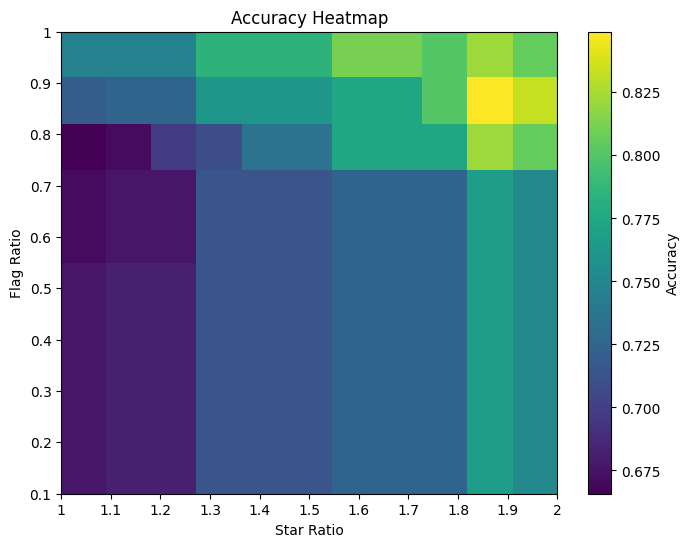

In [42]:
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_matrix, cmap='viridis', aspect='auto', origin='lower', extent=[min(star_ratios), max(star_ratios), min(flag_ratios), max(flag_ratios)])
plt.colorbar(label="Accuracy")
plt.xticks(star_ratios, labels=[str(s) for s in star_ratios])
plt.yticks(flag_ratios, labels=[str(f) for f in flag_ratios])
plt.xlabel("Star Ratio")
plt.ylabel("Flag Ratio")
plt.title("Accuracy Heatmap")

# Save the plot with high quality
plt.savefig("accuracy_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()